In [1]:
# !pip install pytorch_lightning
# !pip install tensorboardX

In [1]:
# import tensorflow
import datetime
import json
import os
import re
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import sklearn.metrics as sm
import tensorboardX as tb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import tqdm
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

np.random.seed(31337)

In [85]:
DATA_DIR = (
    "../botify/data/"
)

In [86]:
tracks_df = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [87]:
unique_artists = tracks_df.artist.unique()

In [88]:
ARTISTS_MAPPING = {artist: idx + 1 for idx, artist in enumerate(unique_artists)}

In [89]:
tracks_df["artist_id"] = tracks_df.artist.apply(
    lambda a: ARTISTS_MAPPING[a] if a in ARTISTS_MAPPING else 0
)

In [90]:
tracks_df.head(8)

,artist,title,track,artist_id
0,Jack Johnson,The Cove,0,1
1,Billy Preston,Nothing from Nothing,1,2
2,Paco De Lucia,Entre Dos Aguas,2,3
3,Josh Rouse,Under Cold Blue Stars,3,4
4,The Dead 60s,Riot Radio (Soundtrack Version),4,5
5,Jorge Drexler,12 segundos de oscuridad,5,6
6,Eric Hutchinson,Food Chain (Album Version),6,7
7,Kanye West,Stronger,7,8


In [13]:
data = pd.read_json(DATA_DIR + "input.json", lines=True)

In [14]:
data = pd.merge(
    data,
    tracks_df[["artist_id", "track"]],
    how="left",
    right_on="track",
    left_on="track",
)

In [15]:
data = data.sort_values(["user", "timestamp"])

In [16]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,artist_id
6433,next,2023-04-15 14:37:19.349,0,12873,1.00,0.000236,18613.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},4344
6441,next,2023-04-15 14:37:19.355,0,18613,0.00,0.000308,43283.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},1015
6448,next,2023-04-15 14:37:19.361,0,43283,0.00,0.000342,47757.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},2500
6456,next,2023-04-15 14:37:19.366,0,47757,0.00,0.000297,21959.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},4758
6462,next,2023-04-15 14:37:19.370,0,21959,0.97,0.000245,2473.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},5396
...,...,...,...,...,...,...,...,...,...
342856,next,2023-04-15 14:41:32.106,9999,36365,0.00,0.000411,24863.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},2046
342864,next,2023-04-15 14:41:32.113,9999,24863,0.01,0.000337,18477.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},3205
342872,next,2023-04-15 14:41:32.118,9999,18477,0.00,0.000693,22905.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},590
342882,next,2023-04-15 14:41:32.128,9999,22905,0.01,0.000314,36286.0,{'CONTEXTUAL_ARTISTS': 'INDEXED'},6647


In [23]:
Pair = namedtuple(
    "Session",
    ["user", "context_track", "context_artist", "next_track", "next_artist", "time"],
)


def get_pairs(user_data):
    pairs = []
    context_track = None
    context_artists = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if context_track is None:
            context_track = row["track"]
            context_artists = row["artist_id"]
        else:
            pairs.append(
                Pair(
                    row["user"],
                    context_track,
                    context_artists,
                    row["track"],
                    row["artist_id"],
                    row["time"],
                )
            )

        if row["message"] == "last":
            context_track = None
            context_artists = None
    return pairs

In [24]:
pairs = pd.DataFrame(
    data.groupby("user").apply(get_pairs).explode().values.tolist(),
    columns=[
        "user",
        "context_track",
        "context_artist",
        "next_track",
        "next_artist",
        "time",
    ],
)

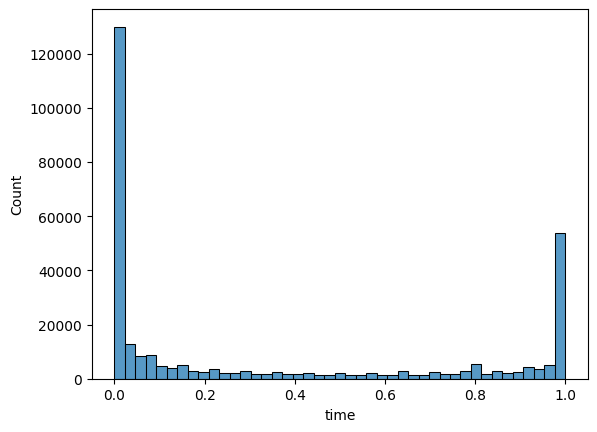

In [25]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [26]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(247931, 30448, 30824)

In [51]:
class Encoder(nn.Module):
    def __init__(self, artists=12000, tracks=50000, emb_dim=128, dropout = 0.5):
        super().__init__()
        self.artists = artists
        self.tracks = tracks
        self.emb_dim = emb_dim
     
        

        self.artist_embedding = nn.Embedding(
            num_embeddings=self.artists,
            embedding_dim=self.emb_dim,
            dtype=torch.float32,
        )
        self.track_embedding = nn.Embedding(
            num_embeddings=self.tracks,
            embedding_dim=self.emb_dim,
            dtype=torch.float32,
        )
        self.dropout = nn.Dropout1d(dropout)
        self.linear_1 = nn.Linear(self.emb_dim, self.emb_dim)

    def forward(self, track_ids, artist_ids):
        track_emb = self.dropout(self.track_embedding(track_ids))
        artist_emb = self.dropout(self.artist_embedding(artist_ids))
        
        out = (artist_emb + track_emb)/2

        return out


class ContextualRanker(pl.LightningModule):
    def __init__(self, artists=12000, tracks=50000, emb_dim=128):
        super().__init__()

        self.artists = artists
        self.tracks = tracks
        self.emb_dim = emb_dim

        self.context_encoder = Encoder(self.artists, self.tracks, emb_dim=self.emb_dim, dropout=0.0)
        self.next_encoder = Encoder(self.artists, self.tracks, emb_dim=self.emb_dim, dropout=0.0)

    def forward(self, x):
        context_emb = self.context_encoder(x[:, 0], x[:, 1])
        next_emb = self.next_encoder(x[:, 2], x[:, 3])
        logits = torch.sum(context_emb * next_emb, dim=1)
        return logits

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch

        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction="mean")
        
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        self.eval()
        loss = self.step(batch, batch_idx, "test_loss")
        self.log("test_loss", loss, prog_bar=prog_bar)


    def training_step(self, batch, batch_idx):
        self.train()
        return self.step(batch, batch_idx, "train_loss")

    def validation_step(self, batch, batch_idx):
        self.eval()
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, verbose=True
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "reduce_on_plateau": True,
            "monitor": "val_loss",
        }
        return [optimizer], [scheduler]

In [54]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        pass
        # self.test_data = self.test_data.assign(
        #     rdm=np.random.random(len(self.test_data))
        # ).assign(avg=self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values),
                torch.from_numpy(self.train_data["time"].values).to(
                    dtype=torch.float32
                ),
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values),
            torch.from_numpy(self.val_data["time"].values).to(dtype=torch.float32),
        )

        if stage == "test" or stage is None:
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data["time"].values).to(dtype=torch.float32),
            )

    def train_dataloader(self):
        return td.DataLoader(
            self.train_dataset, batch_size=4096, shuffle=True, num_workers=8
        )

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=4096, num_workers=8)

    def test_dataloader(self):
        return td.DataLoader(
            self.test_dataset, batch_size=512, shuffle=False, num_workers=8
        )

In [55]:
EMB_SIZE = 128
net = ContextualRanker(emb_dim=EMB_SIZE)
data_module = ContextualRankerData(
    train_data,
    val_data,
    test_data,
    features=["context_track", "context_artist", "next_track", "next_artist"],
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=400,
    accelerator="mps",
    devices=1,
    precision=32,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=10),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ],
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [91]:
%load_ext tensorboard

In [ ]:
!cd ..;tensorboard --logdir HW/lightning_logs/ --host localhost --port 6006

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.12.1 at http://localhost:6006/ (Press CTRL+C to quit)
W0416 02:40:44.107362 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_1'
W0416 02:40:44.107494 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_0'
W0416 02:40:54.126576 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_4'
W0416 02:40:54.126652 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_3'
W0416 02:41:09.149458 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_16'
W0416 02:41:09.149652 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_12'
W0416 02:41:09.149674 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_11'
W0416 02:41:09.149690 6153465856 plugin_event_multiplexer.py:266] Deleting accumulator 'version_15'
W0416 12:33:19.700874 6153465856 plugin_event_multiplexer.py:266] 

In [ ]:
trainer.fit(net, data_module)

In [59]:
best = ContextualRanker.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    #'/Users/kliakhnovich/DEV/MADE/rec_sys_2023/recsys-itmo-spring-2023/jupyter/lightning_logs/version_6/checkpoints/epoch=63-step=4864.ckpt',
    embedding_dim=EMB_SIZE,
)

In [60]:
trainer.test(net, data_module)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10706011205911636
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10706011205911636}]

In [61]:
trainer.test(best, data_module)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10705920308828354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10705920308828354}]

## Compute top recommendations

In [62]:
net = best

In [63]:
net = net.eval()

In [64]:
model = net
model.eval()
with torch.no_grad():
    context_embs = tracks_df.apply(
        lambda x: model.context_encoder( torch.tensor([x["track"]]),torch.tensor([x["artist_id"]])), axis=1
    )
    next_embs = tracks_df.apply(
        lambda x: model.next_encoder( torch.tensor([x["track"]]),torch.tensor([x["artist_id"]])), axis=1
    )
    
    context_embs = torch.cat(list(context_embs.values))
    next_embs = torch.cat(list(next_embs.values))

In [65]:
next_embs.shape, context_embs.shape

(torch.Size([50000, 128]), torch.Size([50000, 128]))

In [68]:
context_embeddings = context_embs
track_embeddings = next_embs 

In [ ]:
k = 100
with open(DATA_DIR + "tracks_with_artists_context_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(tracks_df.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]

        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()

        rf.write(json.dumps(recommendation) + "\n")

In [70]:
track = 7
embedding = context_embeddings[track]
tracks_df.loc[tracks_df["track"] == track, ["artist", "title"]]

,artist,title
7,Kanye West,Stronger


In [72]:
k = 10
#neighbours = np.argsort(-np.dot(track_embeddings, embedding), k)[:k]
neighbours = np.argsort(-torch.sigmoid(track_embeddings @ embedding))[:k].numpy()
tracks_df.loc[tracks_df["track"].isin(neighbours), ["artist", "title"]]

,artist,title
1305,Jason Derulo,Whatcha Say
2241,Kid Cudi,Cudi Zone
2254,Alliance Ethnik,Représente
2659,Young Money featuring Lloyd,BedRock (Radio Edit) (feat.Lloyd)
2790,Kid Cudi,Up Up & Away
2939,Alliance Ethnik,Sincerité Et Jalousie
3755,Sheena Easton,Strut (1993 Digital Remaster)
4632,Beyoncé,Naughty Girl
15216,Panteón Rococó,Reality Shock
23694,Masta Killa,Ringing Bells
